In [37]:
# !pip install matplotlib tqdm numpy

In [38]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.plotters import plot_average_execution_time
from utils.parse import parse_task_file
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [39]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [ ]:
# process task sets for Plot 1 and 2 (by number of tasks)

def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        for subfolder in subfolders:
            print(f"Subfolder: {subfolder}")
            num_tasks = 100
            print(f"\nProcessing {num_tasks} tasks in {subfolder}")
            print(f"Evaluating algorithm: {config["alg"].name}")
            schedule_stats = review_task_sets_in_parallel_multi(algorithm=config["alg"],
                                                            folder_name=subfolder,
                                                            num_processors=config["processors"],
                                                            num_clusters=config["clusters"],
                                                            heuristic=config["heuristic"],
                                                            number_of_workers=worker_quantity)
            # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
            # execution_times[num_tasks] = success_rate
        end_time = time() - start_time

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": end_time
            }
        )

    return execution_times

In [ ]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "sorting": 'du',
        "processors": 8,
        "clusters": 4,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor")


Executing with: 10 workers.
Subfolder: tasksets-multiprocessor/1

Processing 100 tasks in tasksets-multiprocessor/1
Evaluating algorithm: PARTITIONED_EDF


Checking task set: tasksets-multiprocessor/1/taskset-22Checking task set: tasksets-multiprocessor/1/taskset-48Checking task set: tasksets-multiprocessor/1/taskset-91Checking task set: tasksets-multiprocessor/1/taskset-46Checking task set: tasksets-multiprocessor/1/taskset-50Checking task set: tasksets-multiprocessor/1/taskset-85Checking task set: tasksets-multiprocessor/1/taskset-2Checking task set: tasksets-multiprocessor/1/taskset-54Checking task set: tasksets-multiprocessor/1/taskset-21Checking task set: tasksets-multiprocessor/1/taskset-96








The task set tasksets-multiprocessor/1/taskset-91 is schedulable because some sufficient condition is met.
The task set tasksets-multiprocessor/1/taskset-2 is schedulable because some sufficient condition is met.The task set tasksets-multiprocessor/1/taskset-54 is schedulable because some sufficient condition is met.The task set tasksets-multiprocessor/1/taskset-46 is schedulable because some sufficient condition is met.The task set tasks

Time taken for 10 workers: 4.217470407485962
Time taken for 11 workers: 4.197558879852295
Time taken for 12 workers: 4.061211347579956


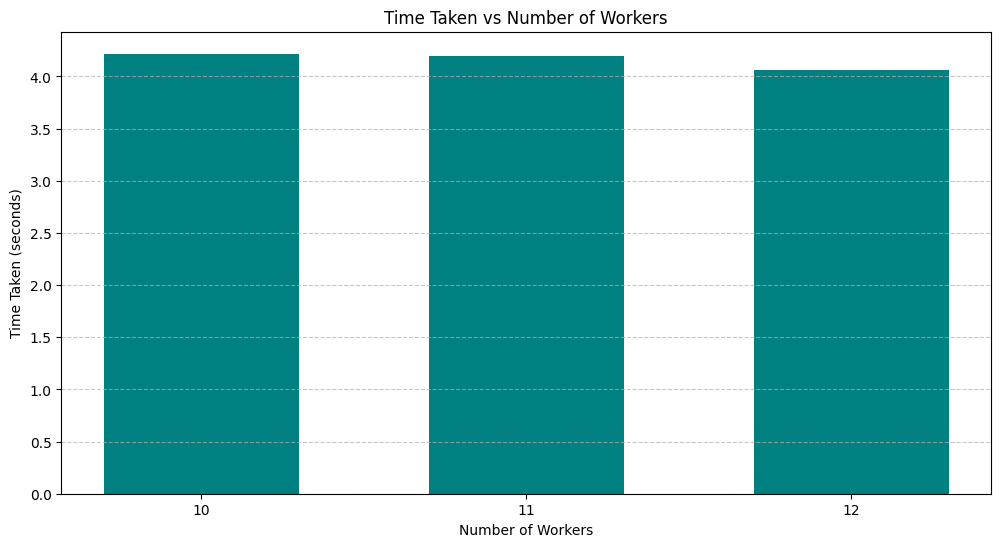

In [48]:
for result in results:
    print(f"Time taken for {result["workers"]} workers: {result["time"]}")

workers = [result["workers"] for result in results]
times = [result["time"] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(workers, times, color='teal', width=0.6)
plt.xlabel('Number of Workers')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Workers')
plt.xticks(workers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()